### Becoming a backprop ninja! 

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
words = open('../lecture 2/names.txt').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [6]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [7]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [8]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3377, grad_fn=<NegBackward0>)

In [9]:
#Time for manual backprop! 

In [10]:
#Step 1: how does loss get affected by logprobs? 
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1/n #we've derived that the gradient will be -1/n for the examples in logprobs that are actually chosen. naturally the ones that are not chosen
                                #have a gradient of 0, so we init a 0 tensor and just put in -1/n with our smart indexing. 
#let's see if this is right:
cmp('logprobs', dlogprobs, logprobs)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


In [11]:
#Step 2: how does loss get affected by probs?
# lobprobs = ln(probs), elementwise we have that our derivatives just follow the rule for ln(x) so we just have 1/x.
dprobs = probs**-1 * dlogprobs #multiply by global derivative dlogprobs (so far) to follow chain rule, dummy
cmp('probs', dprobs, probs) #yeehaw

probs           | exact: True  | approximate: True  | maxdiff: 0.0


In [12]:
#Step 3: how does loss get affected by counts and couns_sum_inv? 
#c = a * b
# but also a broadcasting thing in our case. we have 2 operations happening under the hood when we do probs = counts * counts_sum_inv. we have the multiplication and a broadcasting
dcounts_sum_inv = (counts * dprobs).sum(1,keepdim=True) #we're summing across the rows because of the multivariate chain rule here. we're broadcasting a 32x1 over a 32x27
                                                        #meaning we're replicating the 32x1 column vector over all 27 rows of the counts matrix. essentially each element of the thing
                                                        #is being used 27 times, and these all have gradients that we're going to sum up. keeping dims so shit works. idk.
dcounts = (counts_sum_inv * dprobs) #no need for the sum as this broadcasts just fine on it's own
cmp("dcounts_sum_inv", dcounts_sum_inv, counts_sum_inv) #Works just fine baby-boo
cmp("counts", dcounts, counts_sum_inv) #This shit don't work. counts here is being used for multiple nodes, counts calculates counts_sum which is then used to calculate counts_sum_inv, and probs
                                       #also uses counts in it's calculation. we need to finish working backwards and propagate through counts_sum first.

dcounts_sum_inv | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: False | approximate: False | maxdiff: 0.5122058987617493


In [13]:
#Step 4: how does loss get affected by counts_sum? 
#counts_sum_inv = 1/counts_sum. derivative of 1/x is -1/x^2. so we just do that 
dcounts_sum = (-1/(counts_sum**2) ) * dcounts_sum_inv #Remember the chain rule dumbass
cmp("dcounts_sum", dcounts_sum, counts_sum)

dcounts_sum     | exact: True  | approximate: True  | maxdiff: 0.0


In [14]:
counts.shape , counts_sum.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [15]:
#Step 5: how does loss get affected by counts? 
dcounts += torch.ones_like(counts) * dcounts_sum #Dawg i don't even know what we're doing here. revisit this! but we're adding the remaining partial chainrule gradient for the 
                                                #rest of dcounts so it should be working fine now. 
cmp("dcounts", dcounts, counts)

dcounts         | exact: True  | approximate: True  | maxdiff: 0.0


In [16]:
#Step 6: how does loss get affected by normlogits? counts = norm_logits.exp(), its just elementwise exp() so the derivative of this is just exp() again
dnormlogits = torch.exp(norm_logits) * dcounts
cmp("dnormlogits", dnormlogits, norm_logits)

dnormlogits     | exact: True  | approximate: True  | maxdiff: 0.0


In [17]:
logits.shape, logit_maxes.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [18]:
#Step 7: how does loss get affected by logits/logit_maxes? norm_logits = logits - logit_maxes
dlogits = dnormlogits.clone() #Not the final one, one more branch like before up there. 
dlogitmaxes = (-dnormlogits).sum(1,keepdim=True)
cmp("dlogitmaxes", dlogitmaxes, logit_maxes)

dlogitmaxes     | exact: True  | approximate: True  | maxdiff: 0.0


In [19]:
logits.max(1, keepdim=True).indices

tensor([[ 1],
        [ 2],
        [19],
        [15],
        [15],
        [25],
        [16],
        [ 3],
        [ 7],
        [ 8],
        [15],
        [ 3],
        [ 6],
        [18],
        [ 7],
        [ 5],
        [ 2],
        [ 1],
        [ 6],
        [19],
        [15],
        [19],
        [ 6],
        [22],
        [23],
        [ 5],
        [22],
        [20],
        [24],
        [ 8],
        [24],
        [13]])

In [20]:
#Step 8: how does loss get affected by logits? logit_maxes = logits.max(1, keepdim=True).values
#temp = torch.zeros_like(logits)
#temp[logits.max(1, keepdim=True).indices] = 1
#dlogits += temp * dlogitmaxes
cmp("dlogits",dlogits, logits)

#My own derivation above ^^^. Approximately true? Let's try karpathys version

dlogits         | exact: False | approximate: True  | maxdiff: 7.916241884231567e-09


In [21]:
#Step 8: how does loss get affected by logits? logit_maxes = logits.max(1, keepdim=True).values
dlogits += F.one_hot(logits.max(1).indices, num_classes= logits.shape[1]) * dlogitmaxes
cmp("dlogits",dlogits, logits)
#Seems better, still proud of myself 

dlogits         | exact: True  | approximate: True  | maxdiff: 0.0


In [22]:
logits.shape, h.shape, W2.shape, b2.shape

(torch.Size([32, 27]),
 torch.Size([32, 64]),
 torch.Size([64, 27]),
 torch.Size([27]))

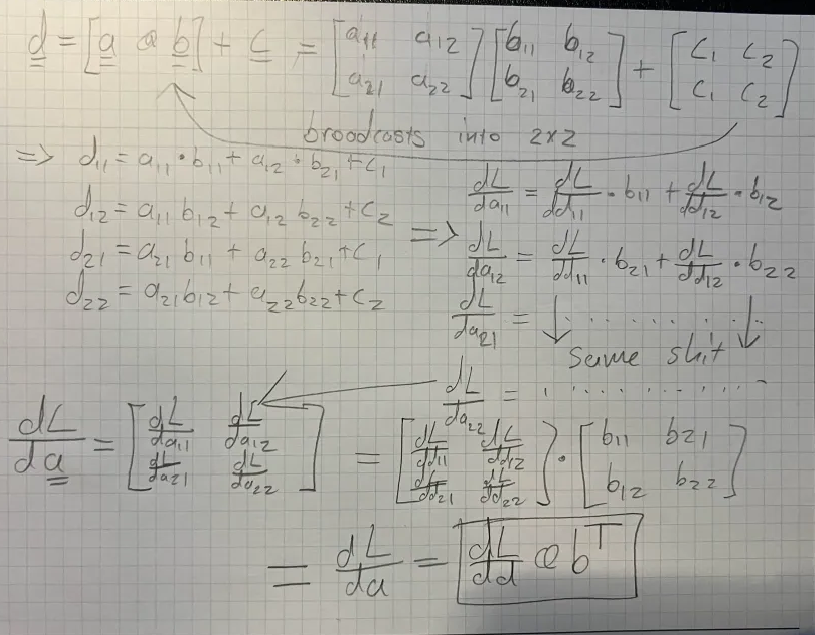

In [23]:
#dL / dc = dL/dd.sum(0)

In [24]:
#Step 9: LINEAR LAYER logits = h @ W2 + b2
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
cmp("dh", dh, h)
cmp("dW2",dW2,W2)
cmp("db2",db2, b2)

dh              | exact: True  | approximate: True  | maxdiff: 0.0
dW2             | exact: True  | approximate: True  | maxdiff: 0.0
db2             | exact: True  | approximate: True  | maxdiff: 0.0


In [25]:
#Step 10: how does loss get affected by hpreact? h = torch.tanh(hpreact)
#This one is easy. it's just elementwise tanh so we just implement the derivative of tanh. 1 / torch.cosh(hpreact) <-- worked but only approximately. 

dhpreact = (1-h**2) * dh
cmp("dhpreact", dhpreact, hpreact)

dhpreact        | exact: True  | approximate: True  | maxdiff: 0.0


In [26]:
bngain.shape, bnbias.shape, bnraw.shape, hpreact.shape

(torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([32, 64]))

In [27]:
#Step 11: Batchnorm parameters! How is loss affected by bngain, bnraw, and bnbias?  hpreact = bngain * bnraw + bnbias

dbngain = (bnraw * dhpreact).sum(0,keepdim=True)
dbnraw = (bngain * dhpreact)
dbnbias = (torch.ones_like(bnbias) * dhpreact).sum(0,keepdim=True) #same but retarded
#dbnbias = dhpreact.sum(0, keepdim=True)
cmp("dbngain", dbngain, bngain)
cmp("dbnraw", dbnraw, bnraw)
cmp("dbnbias", dbnbias, bnbias)

dbngain         | exact: True  | approximate: True  | maxdiff: 0.0
dbnraw          | exact: True  | approximate: True  | maxdiff: 0.0
dbnbias         | exact: True  | approximate: True  | maxdiff: 0.0


In [28]:
bndiff.shape, bnvar_inv.shape

(torch.Size([32, 64]), torch.Size([1, 64]))

In [29]:
#Step 12: how is loss affected by bndiff and bnvarinv? bnraw = bndiff * bnvar_inv

dbndiff = (bnvar_inv * dbnraw)
dbnvarinv = (bndiff * dbnraw).sum(0,keepdims=True)
cmp("dbndiff", dbndiff, bndiff) #Incorrect so far because there's another gradient we gotta add to this one. 
cmp("dbnvarinv", dbnvarinv, bnvar_inv)


dbndiff         | exact: False | approximate: False | maxdiff: 0.0012238738127052784
dbnvarinv       | exact: True  | approximate: True  | maxdiff: 0.0


In [30]:
#Step 13: how is loss affected by bnvar? 
#bnvar_inv = (bnvar + 1e-5)**-0.5. let's differentiate this weird looking thing
local_13 = (-0.5*(bnvar + 1e-5)**-1.5)
dbnvar = local_13 * dbnvarinv
cmp("dbnvar", dbnvar, bnvar)

dbnvar          | exact: True  | approximate: True  | maxdiff: 0.0


In [31]:
bnvar.shape,bndiff2.shape, n

(torch.Size([1, 64]), torch.Size([32, 64]), 32)

In [32]:
# Useful note:
# When we have a sum in the forward pass, the backward pass always involves a broadcasting. 
# When we have a broadcasting in the forward pass, the backward pass will always have a sum.

In [33]:
#Step 14: how is loss affected by bndiff2? bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)

dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dbnvar
cmp("dbndiff2", dbndiff2,bndiff2)

dbndiff2        | exact: True  | approximate: True  | maxdiff: 0.0


In [34]:
#Step 15: how is loss affected by bndiff ? bndiff2 = bndiff**2
dbndiff += 2 * bndiff * dbndiff2

cmp("dbndiff", dbndiff, bndiff)

dbndiff         | exact: True  | approximate: True  | maxdiff: 0.0


In [35]:
bndiff.shape, hprebn.shape, bnmeani.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [36]:
#example : a = b - c
#  [c1 c2]
#  [a11 a12] == [b11 - c1    b12 - c2]
#  [a21 a22] == [b21 - c1    b22 - c2]
# a11 = b11 - c1
# a12 = b12 - c2
# a21 = b21 - c1
# a22 = b22 - c2

#the forward pass involves a broadcasting, so the backwardpass must involve a summation. we're broadcasting and copying rows, so we need to sum along the 0'th axis

In [37]:
#Step 16: how is loss affected by hprebn, bnmeani? bndiff = hprebn - bnmeani
dhprebn = (dbndiff.clone())
dbnmeani = (-torch.ones_like(bndiff) * dbndiff).sum(0,keepdim=True)
cmp("dhprebn", dhprebn, hprebn) #SECOND PORTION FROM SECOND BRANCH INCOMING
cmp("dbnmeani", dbnmeani, bnmeani)

dhprebn         | exact: False | approximate: False | maxdiff: 0.0009879923891276121
dbnmeani        | exact: True  | approximate: True  | maxdiff: 0.0


In [38]:
bnmeani.shape, hprebn.shape

(torch.Size([1, 64]), torch.Size([32, 64]))

In [39]:
#Summation in forward pass, broadcasting in backward pass.

In [40]:
#Step 17: how does hprebn affect the loss? bnmeani = 1/n*hprebn.sum(0, keepdim=True)

dhprebn += 1/n * torch.ones_like(hprebn) * dbnmeani

cmp("dhprebn", dhprebn, hprebn)

dhprebn         | exact: True  | approximate: True  | maxdiff: 0.0


In [41]:
#Step 9: LINEAR LAYER logits = h @ W2 + b2
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
cmp("dh", dh, h)
cmp("dW2",dW2,W2)
cmp("db2",db2, b2)

dh              | exact: True  | approximate: True  | maxdiff: 0.0
dW2             | exact: True  | approximate: True  | maxdiff: 0.0
db2             | exact: True  | approximate: True  | maxdiff: 0.0


In [42]:
#Step 18: how does embcat, w1, and b1 affect loss? #hprebn = embcat @ W1 + b1 # hidden layer pre-activation
#similar to our linear layer from before: 
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
cmp("dempcat", dembcat, embcat)
cmp("dW1", dW1, W1)
cmp("db1", db1, b1)

dempcat         | exact: True  | approximate: True  | maxdiff: 0.0
dW1             | exact: True  | approximate: True  | maxdiff: 0.0
db1             | exact: True  | approximate: True  | maxdiff: 0.0


In [43]:
#Step 19: how does emb affect loss? #embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
#I think it's just 1? why would concatenating them affect any grads? 
demb = dembcat.view([32,3,10])
demb.shape
cmp("demb", demb, emb)

demb            | exact: True  | approximate: True  | maxdiff: 0.0


In [44]:
#okay my thinking is that the gradient just flows at the correct indices? 

In [45]:
#Step 20: how does C[Xb] affect loss? #emb = C[Xb] # embed the characters into vectors
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j] 

cmp("dC", dC, C)

dC              | exact: True  | approximate: True  | maxdiff: 0.0


In [46]:
#Exercise 2: backprop through cross_ent but all in one go. look at mathematical expession of the loss, take the derivative, simplify, write it out

#forward pass:
#before: 
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()


#now: 
loss_fast = F.cross_entropy(logits,Yb)
print(loss_fast.item(), "diff:", (loss_fast-loss).item())

3.337740659713745 diff: 0.0


In [48]:
#Backward pass
dlogits = F.softmax(logits,1)
dlogits[range(n),Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 7.2177499532699585e-09


In [54]:
#Exercise 3: backprop through batch_norm but all in one go. look at mathematical expession of the loss, take the derivative, simplify, write it out

#before: 
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

#now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0,keepdim=True)) / torch.sqrt(hprebn.var(0,keepdim=True, unbiased = True) + 1e-5) + bnbias
print("Max_diff: ", (hpreact_fast - hpreact).abs().max())

Max_diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [55]:
#Backward pass: 
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [56]:
#PUT IT ALL TOGETHER! 

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

max_steps = 200000
batch_size = 32
n = batch_size
lossi = []

with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #     break

4137
      0/ 200000: 3.3361
  10000/ 200000: 2.4400
  20000/ 200000: 2.0253
  30000/ 200000: 2.2615
  40000/ 200000: 2.3598
  50000/ 200000: 2.2859
  60000/ 200000: 2.2466
  70000/ 200000: 2.4465
  80000/ 200000: 2.2063
  90000/ 200000: 2.3604
 100000/ 200000: 2.0943
 110000/ 200000: 1.9019
 120000/ 200000: 2.0837
 130000/ 200000: 2.5102
 140000/ 200000: 1.9361
 150000/ 200000: 2.1083
 160000/ 200000: 2.0505
 170000/ 200000: 2.1629
 180000/ 200000: 1.8176
 190000/ 200000: 2.1102


In [57]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [58]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.148099184036255
val 2.1659233570098877


In [61]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

azie.
marqarleez.
zaxlyn.
sson.
shim.
lididha.
bry.
oson.
jaxly.
korah.
alynn.
sion.
rymer.
nevell.
made.
zelde.
kis.
brana.
jayanna.
olitkylory.
